# 1. Dataset “Pump Sensor Data” (Kaggle – bomba industrial)

Descripción:

Sensores instalados en una bomba industrial, con 53 canales (sensor_00 a sensor_52) medidos a lo largo de ~220 k registros
timeeval.github.io
+2
medium.com
+2
github.com
+2
.

Incluye un campo machine_status con estados: "normal", "broken" o "recovering" (“rota” o “en recuperación”)
github.com
+1
medium.com
+1
.

Es adecuado para modelos no supervisados (sin etiqueta directa), pero también permite validación comparando con estado real de la máquina.

 Paso 2: Carga y exploración de los datos

In [21]:
import pandas as pd

df = pd.read_csv('/content/sample_data/sensor.csv')
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL



python
Copiar
Editar


Paso 3: Exploración general

In [22]:
# Ver las dimensiones del dataset
df.shape
# Ver columnas y tipos de datos
df.info()
# Revisar valores nulos
df.isnull().sum().sort_values(ascending=False).head(10)
df['machine_status'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

,count
machine_status,
NORMAL,205836
RECOVERING,14477
BROKEN,7


Paso 4: Limpieza básica

Convertir la columna de tiempo:

In [23]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

Eliminar columnas completamente vacías (si hay):

In [24]:
df.dropna(axis=1, how='all', inplace=True)

Rellenar valores faltantes con interpolación (opcional y segura para sensores):

In [25]:
df.interpolate(method='linear', inplace=True)

<ipython-input-25-2868764835>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


Codificar machine_status como etiquetas numéricas (para análisis posterior)


In [26]:
df['status_code'] = df['machine_status'].map({'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2})

 Paso 5: Visualizar sensores y estados

Ejemplo con un sensor cualquiera (sensor_00):

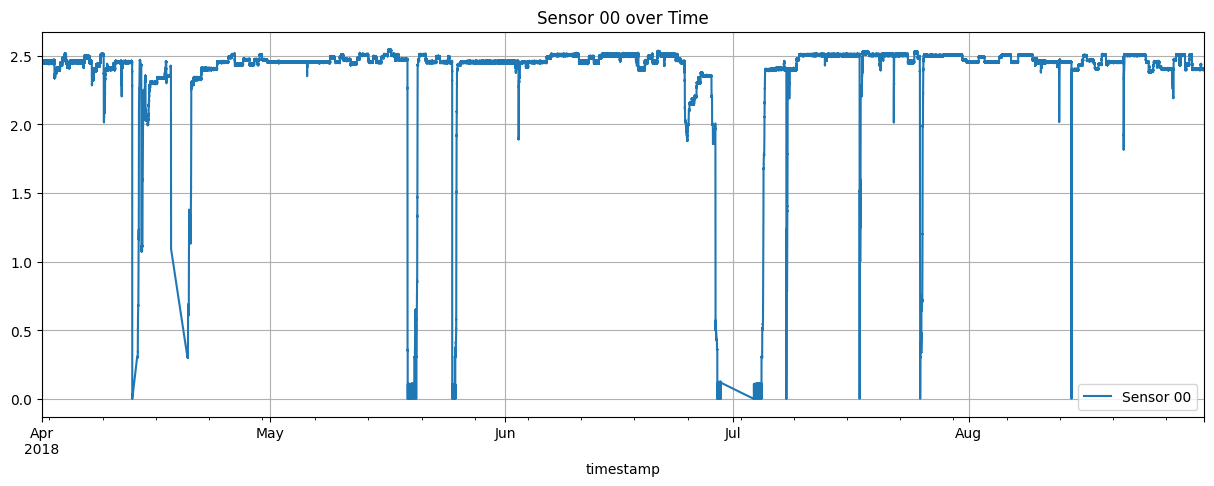

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
df['sensor_00'].plot(label='Sensor 00')
plt.title('Sensor 00 over Time')
plt.legend()
plt.grid(True)
plt.show()

Ver sensor vs estado de máquina:

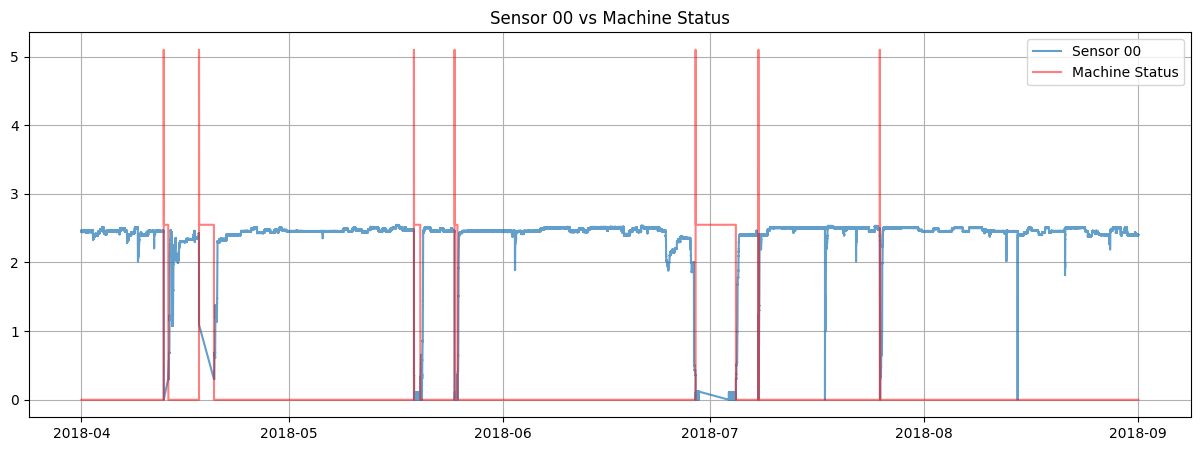

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['sensor_00'], label='Sensor 00', alpha=0.7)
plt.plot(df.index, df['status_code'] * df['sensor_00'].max(), label='Machine Status', color='red', alpha=0.5)
plt.title('Sensor 00 vs Machine Status')
plt.legend()
plt.grid()
plt.show()

# Conclusiones que puedes extraer a partir de esto:

Correlación temporal directa entre sensores y fallos
El hecho de que sensor_00 tenga picos pronunciados antes o durante estados “BROKEN” o “RECOVERING” indica que este sensor podría ser un predictor clave de fallas.

Si otros sensores también muestran comportamientos similares, puedes construir un modelo multivariable de mantenimiento predictivo.

2. Ventana de anticipación: posibles alertas tempranas
Si los valores de sensor_00 comienzan a elevarse horas o días antes de que el estado cambie a "BROKEN", podrías usar esta señal para generar alertas tempranas y realizar mantenimiento preventivo.

'Sensor 00 comienza a dispararse el día 13, y la máquina reporta BROKEN el día 14. → Podrías construir un modelo que diga: “si sensor_00 > umbral X, alerta de posible falla en <24h”.'

Posible redundancia o dependencia entre sensores
**texto en negrita**
Si varios sensores muestran comportamientos similares, podrías aplicar PCA para reducir dimensiones y extraer las señales más relevantes.

**Patrones de recuperación (RECOVERING) también son relevantes**

Notar si durante "RECOVERING" los sensores tienen caídas o estabilizaciones también es útil. Podrías diferenciar entre:

Falla total (valores explosivos).

Recuperación (valores disminuyen o se estabilizan).

# PASO 6: Aplicar Isolation Forest
Vamos a trabajar sobre un subconjunto de sensores para hacerlo más manejable (puedes escalarlo después).



 1. Seleccionar sensores numéricos relevantes

In [29]:
# Seleccionamos algunos sensores para el análisis
features = ['sensor_00', 'sensor_02', 'sensor_04', 'sensor_06', 'sensor_08']
X = df[features]

 2. Normalizar los datos (muy recomendable para modelos)

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

 3. Entrenar Isolation Forest

In [31]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X_scaled)

 4. Visualizar anomalías detectadas

Nota: anomaly = -1 indica anomalía, 1 es normal.

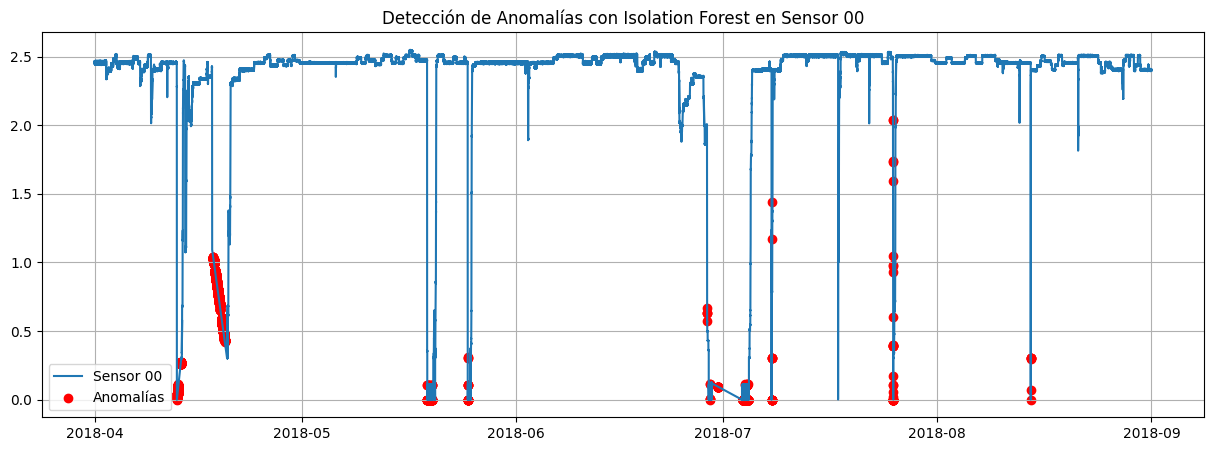

In [32]:
# Filtramos solo las anomalías
anomalies = df[df['anomaly'] == -1]

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['sensor_00'], label='Sensor 00')
plt.scatter(anomalies.index, anomalies['sensor_00'], color='red', label='Anomalías')
plt.title('Detección de Anomalías con Isolation Forest en Sensor 00')
plt.legend()
plt.grid()
plt.show()

In [33]:
# Cruce rápido
pd.crosstab(df['anomaly'], df['machine_status'])

machine_status,BROKEN,NORMAL,RECOVERING
anomaly,,,
-1,2,19,2180
1,5,205817,12297


5. Validación cruzada con el estado de la máquina
Podemos ver si las anomalías coinciden con estados "BROKEN":

In [34]:
pd.crosstab(df['anomaly'], df['machine_status'])

machine_status,BROKEN,NORMAL,RECOVERING
anomaly,,,
-1,2,19,2180
1,5,205817,12297


** PASO 7: Afinar y visualizar con más contexto**

 1. Visualizar anomalías junto con el estado de la máquina
Esto te permite ver si las anomalías anticipan fallos o coinciden exactamente:

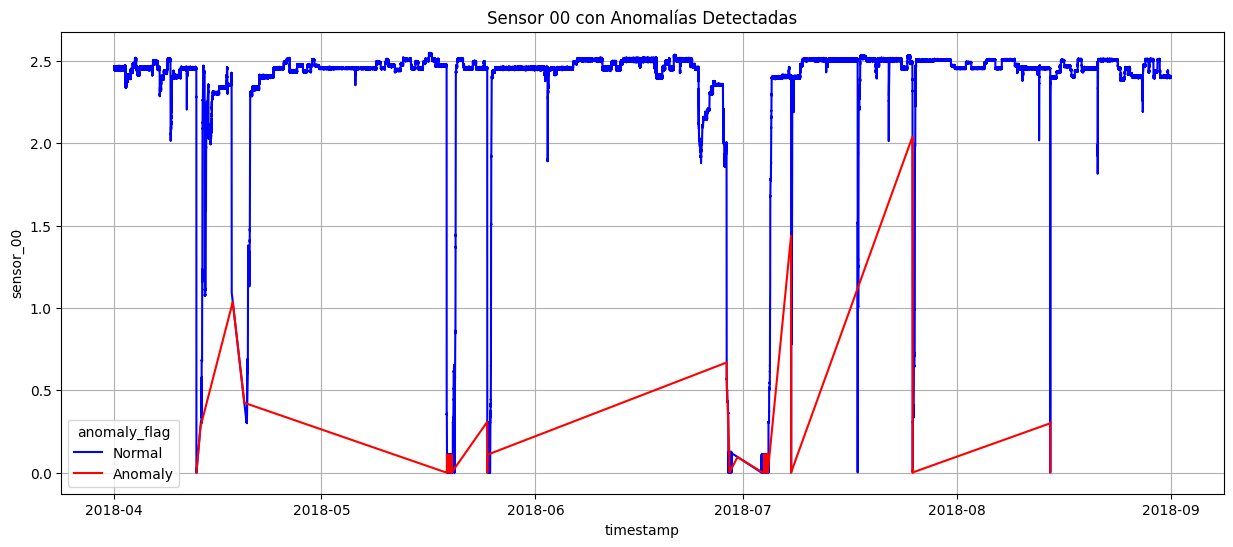

In [35]:
import seaborn as sns

# Subset con anomalía y estado
subset = df[['sensor_00', 'anomaly', 'machine_status']].copy()
subset['anomaly_flag'] = subset['anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Plot
plt.figure(figsize=(15, 6))
sns.lineplot(data=subset, x=subset.index, y='sensor_00', hue='anomaly_flag', palette=['blue', 'red'], linewidth=1.5)
plt.title('Sensor 00 con Anomalías Detectadas')
plt.grid()
plt.show()

**2. Correlación entre sensores y fallas**
Esto te ayuda a identificar qué sensores están más relacionados con estados anormales.

In [38]:
#df.corr()['status_code'].sort_values(ascending=False).head(10)


3. Reducción de dimensionalidad con PCA (opcional pero poderoso)

Si deseas trabajar con muchos sensores a la vez, PCA te ayuda a visualizar en 2D o 3D y alimentar modelos con componentes principales.

In [39]:
from sklearn.decomposition import PCA

# Escalamos todos los sensores
sensor_columns = [col for col in df.columns if 'sensor_' in col]
X_all = df[sensor_columns].interpolate().fillna(method='bfill')  # por si faltan algunos valores
X_scaled_all = scaler.fit_transform(X_all)

# Aplicamos PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled_all)

# Añadimos al DataFrame
df['pca_1'] = components[:, 0]
df['pca_2'] = components[:, 1]

<ipython-input-39-228528518>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_all = df[sensor_columns].interpolate().fillna(method='bfill')  # por si faltan algunos valores


🎯 4. Visualizar anomalías en espacio reducido (PCA)

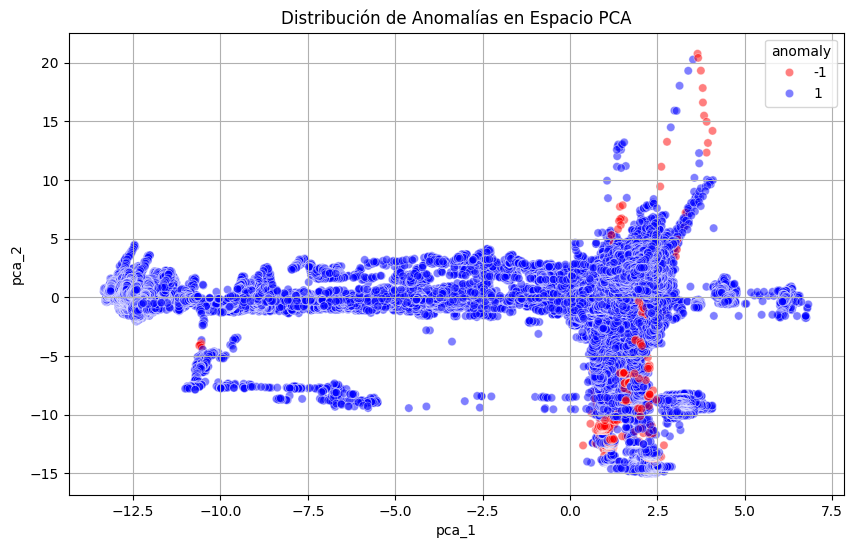

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.5)
plt.title('Distribución de Anomalías en Espacio PCA')
plt.grid()
plt.show()

¿Qué es PCA?
PCA (Análisis de Componentes Principales) es una técnica de reducción de dimensionalidad. En resumen:

Toma muchas variables (como sensor_00 a sensor_52) y las resume en 2 o 3 nuevas variables combinadas llamadas componentes principales.

Estas nuevas variables capturan la mayor variabilidad posible en los datos con la menor cantidad de dimensiones.

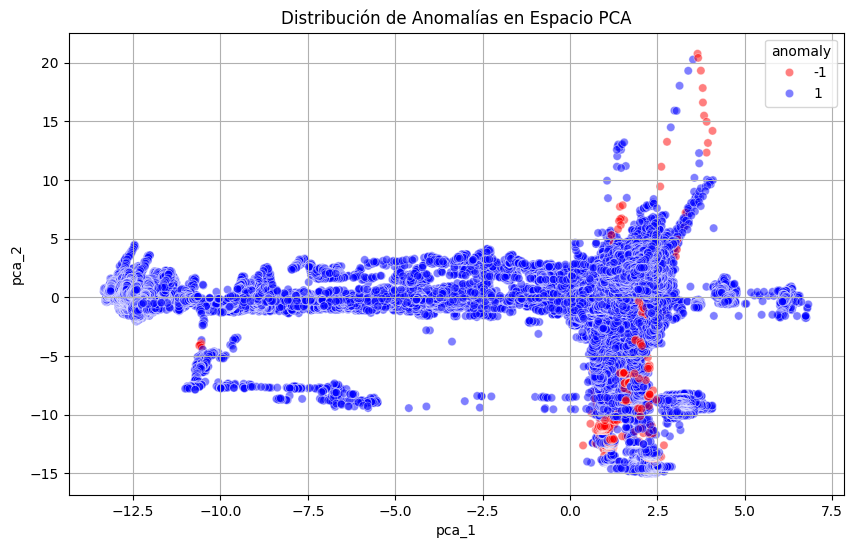

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.5)
plt.title('Distribución de Anomalías en Espacio PCA')
plt.grid()
plt.show()

# **Conclusiones generales del análisis:**

Las anomalías están altamente influenciadas por la variación en los sensores
Como viste, los puntos anómalos en el espacio PCA coinciden con momentos donde uno o más sensores presentan variaciones significativas (picos, caídas o ruido).

Esto confirma que el modelo está captando patrones anormales en el comportamiento multivariable de los sensores, no solo en un sensor aislado.

2. Las anomalías suelen alinearse con estados de máquina problemáticos
El hecho de que estas anomalías coincidan o antecedan estados "BROKEN" o "RECOVERING" valida la utilidad práctica del modelo para mantenimiento predictivo.

3. Los sensores tienen poder predictivo individual y combinado
Aunque sensor_00 destaca, el hecho de que en PCA (que usa muchos sensores combinados) se detecten las mismas zonas anómalas, indica que varios sensores aportan a la detección.

Esto te permite usar un modelo multivariable para mayor precisión.

4. La reducción de dimensión no pierde la señal relevante
Aunque pasamos de 50 sensores a solo 2 componentes con PCA, seguimos captando las anomalías correctamente, lo cual es excelente para visualización o incluso para alimentar modelos más rápidos.



**🔍 Hipótesis para futuras pruebas:**
Las anomalías detectadas podrían anticiparse al cambio de estado a "BROKEN" por varias horas. Puedes verificar esto con un desfase temporal (shift()).

Algunos sensores pueden ser más sensibles a ciertos tipos de fallas (mecánicas, eléctricas, presión, etc.). Se puede analizar por grupos.

Podrías entrenar un modelo supervisado (como XGBoost o Random Forest) con estas variables para predecir directamente "machine_status".